In [23]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Upload the dataset file from your computer (Colab)
uploaded = files.upload()
if not uploaded:
    raise ValueError("No file uploaded. Please upload an Excel (.xlsx) or CSV (.csv) file.")

file_name = list(uploaded.keys())[0]
file_path = Path(file_name)

# Load the spreadsheet / table
if file_path.suffix.lower() in [".xlsx", ".xls"]:
    df = pd.read_excel(file_name)
elif file_path.suffix.lower() == ".csv":
    df = pd.read_csv(file_name)
else:
    raise ValueError(f"Unsupported file type: {file_path.suffix}. Please upload .xlsx or .csv.")

df.columns = [c.strip() for c in df.columns]  # clean header whitespace

print("Loaded file:", file_name)
print("Data shape (rows, columns):", df.shape)

df.head()



Saving Data_english.xlsx to Data_english (1).xlsx
Loaded file: Data_english (1).xlsx
Data shape (rows, columns): (100, 9)


,cycle,HOME,target_compartment,target_angle_deg,measured_angle_deg,error_deg,success_1_0,I_idle_mA,I_peak_mA
0,1,0,A,90,92,2,1,90,460
1,2,3,A,90,94,4,1,90,470
2,3,4,A,90,92,2,1,90,490
3,4,4,A,90,91,1,1,90,490
4,5,2,A,90,90,0,1,90,480


In [24]:
# Ensure numeric columns (based on your English headers)
num_cols = [
    "cycle",
    "HOME",
    "target_angle_deg",
    "measured_angle_deg",
    "error_deg",
    "success_1_0",
    "I_idle_mA",
    "I_peak_mA"
]

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Derived columns
df["abs_error_deg"] = df["error_deg"].abs()
df["failure"] = 1 - df["success_1_0"]
df["cumulative_failures"] = df["failure"].cumsum()

# 95th percentile of absolute error
p95_abs = np.percentile(df["abs_error_deg"].dropna(), 95)

# Clean text columns (useful for grouping/plots)
if "target_compartment" in df.columns:
    df["target_compartment"] = df["target_compartment"].astype(str).str.strip()

print(f"P95 absolute error (deg): {p95_abs:.3f}")
df.head()


P95 absolute error (deg): 4.050


,cycle,HOME,target_compartment,target_angle_deg,measured_angle_deg,error_deg,success_1_0,I_idle_mA,I_peak_mA,abs_error_deg,failure,cumulative_failures
0,1,0,A,90,92,2,1,90,460,2,0,0
1,2,3,A,90,94,4,1,90,470,4,0,0
2,3,4,A,90,92,2,1,90,490,2,0,0
3,4,4,A,90,91,1,1,90,490,1,0,0
4,5,2,A,90,90,0,1,90,480,0,0,0


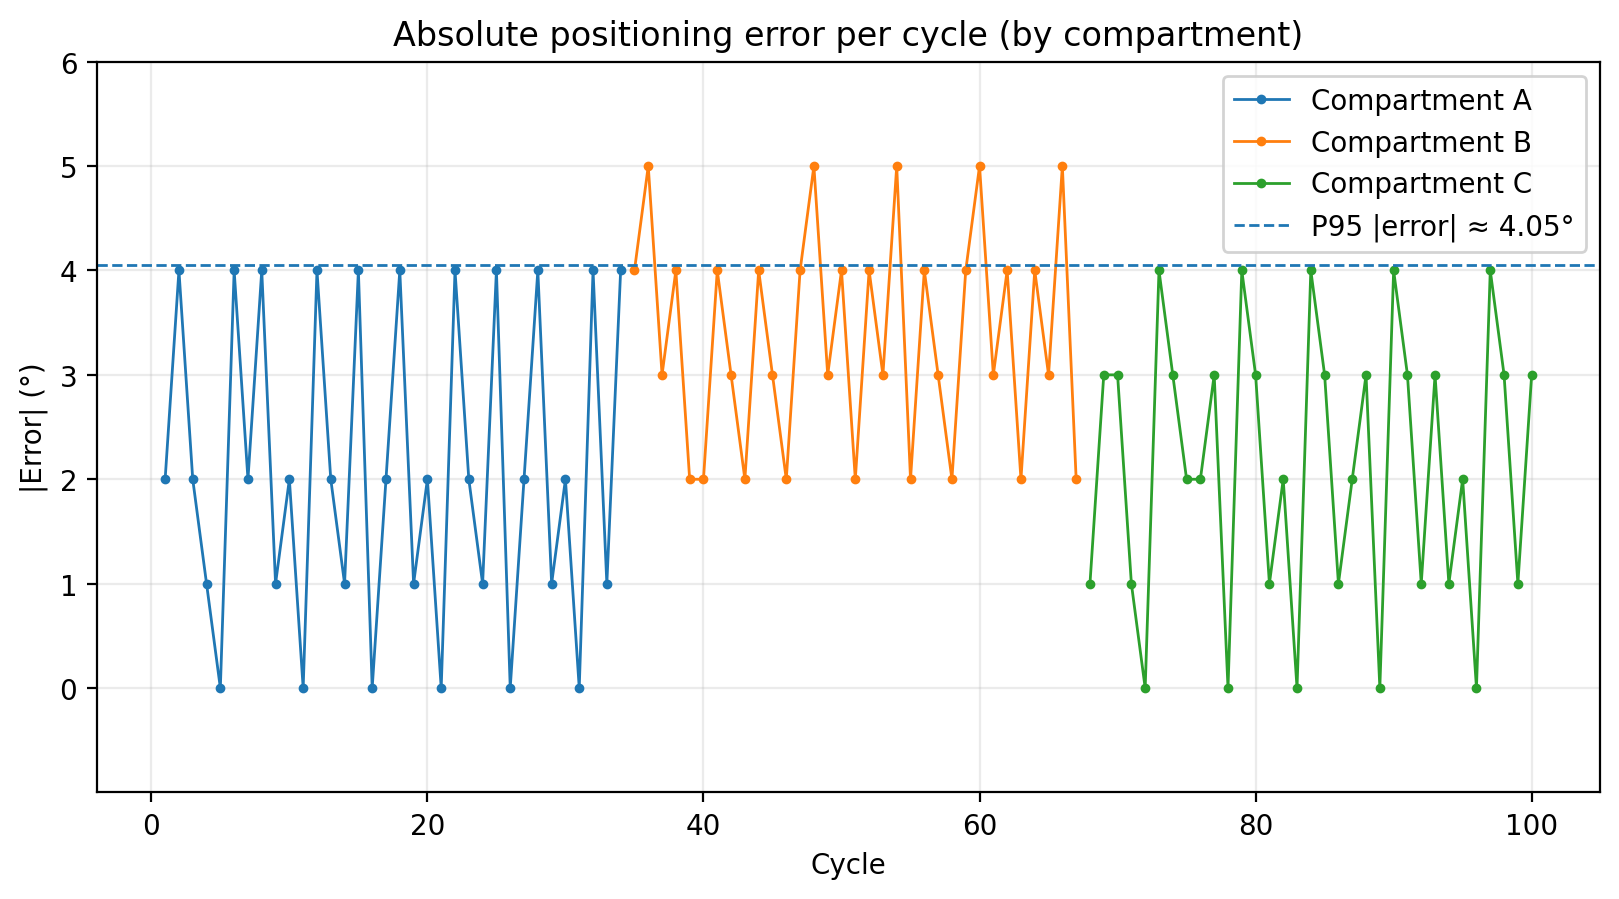

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path("outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

df["target_compartment"] = df["target_compartment"].astype(str).str.strip()
df["abs_error_deg"] = df["error_deg"].abs()
p95_abs = np.percentile(df["abs_error_deg"].dropna(), 95)

plt.figure(figsize=(8.2, 4.6), dpi=200)

color_map = {"A": "tab:blue", "B": "tab:orange", "C": "tab:green"}

for comp in ["A", "B", "C"]:
    sub = df[df["target_compartment"] == comp].sort_values("cycle")
    plt.plot(
        sub["cycle"], sub["abs_error_deg"],
        marker="o", linewidth=1, markersize=2.5,
        label=f"Compartment {comp}",
        color=color_map[comp]
    )

plt.axhline(p95_abs, linestyle="--", linewidth=1, label=f"P95 |error| ≈ {p95_abs:.2f}°")

y_max = max(6, float(np.ceil(df["abs_error_deg"].max() + 1)))
plt.ylim(-1, y_max)
plt.yticks(np.arange(0, y_max + 0.1, 1))

plt.grid(True, alpha=0.25)
plt.title("Absolute positioning error per cycle (by compartment)")
plt.xlabel("Cycle")
plt.ylabel("|Error| (°)")

# Legend inside (top-right usually works well here)
plt.legend(loc="upper right", frameon=True, framealpha=0.85)

plt.tight_layout()

base_name = "abs_positioning_error_by_compartment"
plt.savefig(FIG_DIR / f"{base_name}.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / f"{base_name}.pdf", bbox_inches="tight")
plt.show()




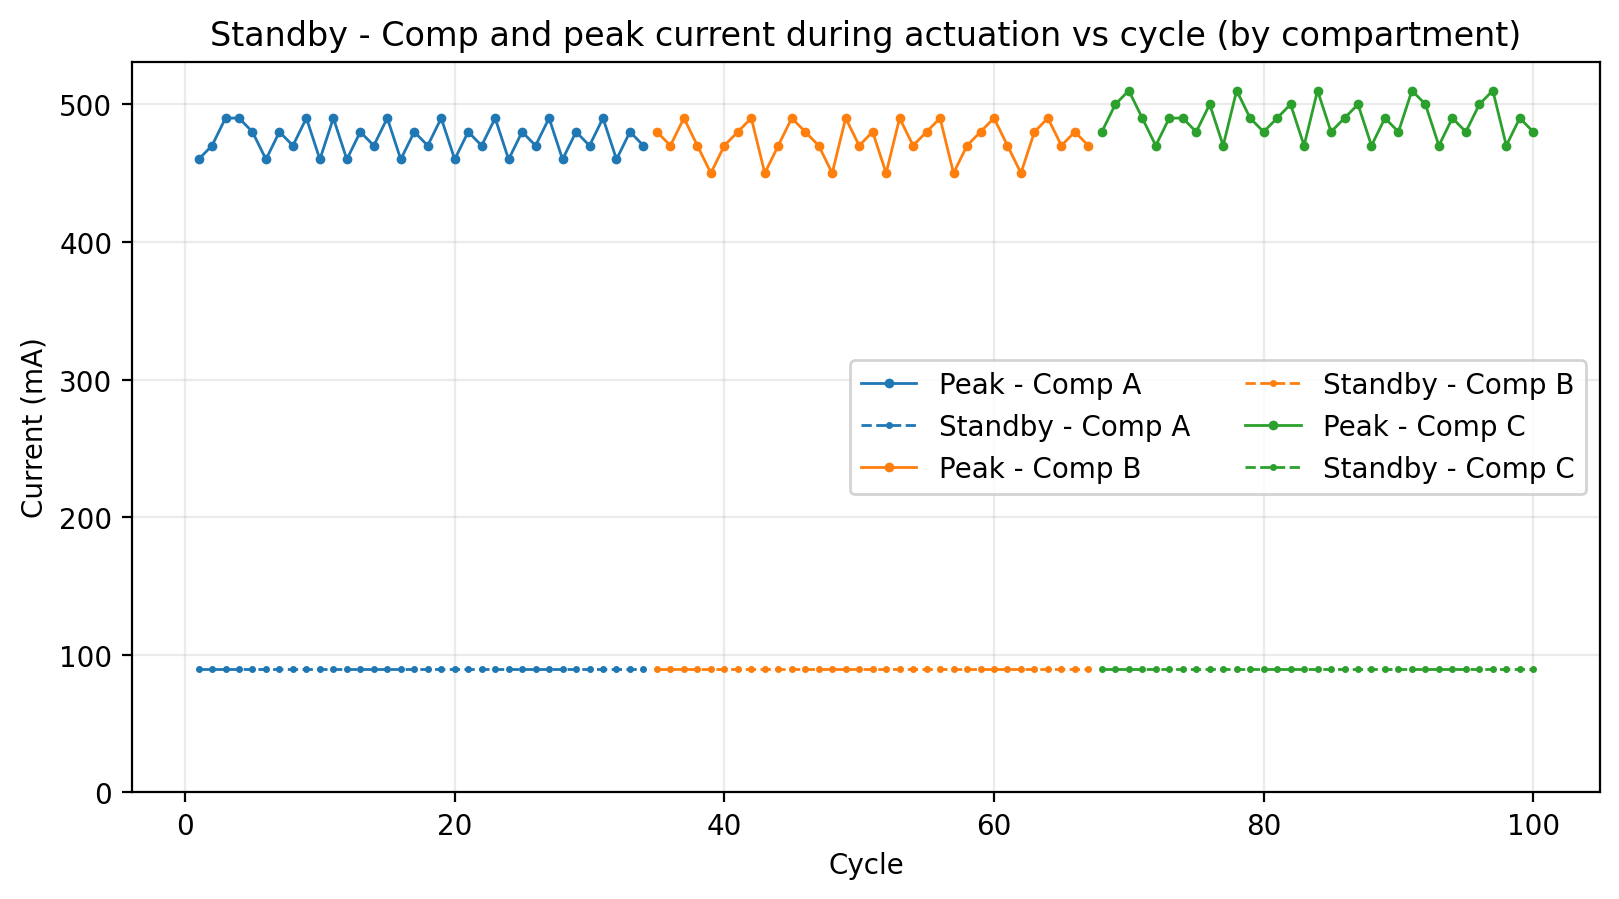

In [34]:
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path("outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8.2, 4.6), dpi=200)

color_map = {"A": "tab:blue", "B": "tab:orange", "C": "tab:green"}

for comp in ["A", "B", "C"]:
    sub = df[df["target_compartment"] == comp].sort_values("cycle")

    # Peak current during actuation
    plt.plot(
        sub["cycle"], sub["I_peak_mA"],
        marker="o", linewidth=1, markersize=2.5,
        label=f"Peak - Comp {comp}",
        color=color_map[comp]
    )

    # Idle/standby current (dashed line, smaller markers)
    plt.plot(
        sub["cycle"], sub["I_idle_mA"],
        marker=".", linewidth=1, markersize=3,
        linestyle="--",
        label=f"Standby - Comp {comp}",
        color=color_map[comp]
    )

plt.ylim(bottom=0)
plt.grid(True, alpha=0.25)
plt.title("Standby - Comp and peak current during actuation vs cycle (by compartment)")
plt.xlabel("Cycle")
plt.ylabel("Current (mA)")

# Legend inside, two columns (like your original)
plt.legend(ncol=2, frameon=True, framealpha=0.85)

plt.tight_layout()

# Save figure (PNG + PDF)
base_name = "idle_peak_current_by_compartment_legend_inside"
plt.savefig(FIG_DIR / f"{base_name}.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / f"{base_name}.pdf", bbox_inches="tight")

plt.show()





In [35]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- output folder ----------
METRICS_DIR = Path("outputs/metrics")
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- safety checks ----------
required_cols = ["cycle", "abs_error_deg", "error_deg", "success_1_0", "I_idle_mA", "I_peak_mA"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for metrics: {missing}. Available columns: {list(df.columns)}")

# Ensure numeric types where needed
for c in ["cycle", "abs_error_deg", "error_deg", "success_1_0", "I_idle_mA", "I_peak_mA"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows that do not have the core measurements
core = df[["cycle", "abs_error_deg", "success_1_0", "I_idle_mA", "I_peak_mA"]].dropna()

# ---------- metrics ----------
n = int(core["cycle"].count())

abs_mean = float(core["abs_error_deg"].mean())
abs_std  = float(core["abs_error_deg"].std(ddof=1))
abs_p95  = float(np.percentile(core["abs_error_deg"], 95))
abs_max  = float(core["abs_error_deg"].max())

success_rate = float(100.0 * core["success_1_0"].mean())

idle_mean = float(core["I_idle_mA"].mean())
idle_std  = float(core["I_idle_mA"].std(ddof=1))

peak_mean = float(core["I_peak_mA"].mean())
peak_std  = float(core["I_peak_mA"].std(ddof=1))

# ---------- table (for display + export) ----------
global_metrics = pd.DataFrame({
    "Metric": [
        "n (cycles)",
        "Success rate (%)",
        "Mean(|error|) (deg)",
        "SD(|error|) (deg)",
        "P95(|error|) (deg)",
        "Max(|error|) (deg)",
        "Mean idle current (mA)",
        "SD idle current (mA)",
        "Mean peak current (mA)",
        "SD peak current (mA)",
    ],
    "Value": [
        n,
        round(success_rate, 2),
        round(abs_mean, 2),
        round(abs_std, 2),
        round(abs_p95, 2),
        round(abs_max, 2),
        round(idle_mean, 2),
        round(idle_std, 2),
        round(peak_mean, 2),
        round(peak_std, 2),
    ]
})

# ---------- save to CSV ----------
csv_path = METRICS_DIR / "global_metrics_summary.csv"
global_metrics.to_csv(csv_path, index=False)

print(f"Saved metrics to: {csv_path}")
global_metrics

Saved metrics to: outputs/metrics/global_metrics_summary.csv


,Metric,Value
0,n (cycles),100.00
1,Success rate (%),100.00
2,Mean(|error|) (deg),2.52
3,SD(|error|) (deg),1.43
4,P95(|error|) (deg),4.05
5,Max(|error|) (deg),5.00
6,Mean idle current (mA),90.00
7,SD idle current (mA),0.00
8,Mean peak current (mA),479.20
9,SD peak current (mA),14.54


In [38]:
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- output folder ----------
METRICS_DIR = Path("outputs/metrics")
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- required columns ----------
required_cols = ["target_compartment", "cycle", "abs_error_deg", "success_1_0", "I_idle_mA", "I_peak_mA"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for per-compartment metrics: {missing}. Available columns: {list(df.columns)}")

# ---------- type cleaning ----------
df["target_compartment"] = df["target_compartment"].astype(str).str.strip()

for c in ["cycle", "abs_error_deg", "success_1_0", "I_idle_mA", "I_peak_mA"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only rows with the core measurements
data = df[required_cols].dropna()

# ---------- aggregation function ----------
def summarize_group(g: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "n_cycles": int(g["cycle"].count()),
        "success_rate_%": round(100.0 * g["success_1_0"].mean(), 2),
        "abs_error_mean_deg": round(float(g["abs_error_deg"].mean()), 2),
        "abs_error_sd_deg": round(float(g["abs_error_deg"].std(ddof=1)), 2),
        "abs_error_p95_deg": round(float(np.percentile(g["abs_error_deg"], 95)), 2),
        "abs_error_max_deg": round(float(g["abs_error_deg"].max()), 2),
        "idle_current_mean_mA": round(float(g["I_idle_mA"].mean()), 2),
        "idle_current_sd_mA": round(float(g["I_idle_mA"].std(ddof=1)), 2),
        "peak_current_mean_mA": round(float(g["I_peak_mA"].mean()), 2),
        "peak_current_sd_mA": round(float(g["I_peak_mA"].std(ddof=1)), 2),
    })

# ---------- compute metrics by compartment ----------
metrics_by_compartment = (
    data.groupby("target_compartment", sort=True)
        .apply(summarize_group, include_groups=False)
        .reset_index()
        .rename(columns={"target_compartment": "compartment"})
)

# Optional: order A, B, C if present
order = ["A", "B", "C"]
if set(order).issubset(set(metrics_by_compartment["compartment"])):
    metrics_by_compartment["compartment"] = pd.Categorical(metrics_by_compartment["compartment"], categories=order, ordered=True)
    metrics_by_compartment = metrics_by_compartment.sort_values("compartment").reset_index(drop=True)

# ---------- save to CSV ----------
csv_path = METRICS_DIR / "metrics_by_compartment.csv"
metrics_by_compartment.to_csv(csv_path, index=False)

print(f"Saved per-compartment metrics to: {csv_path}")
metrics_by_compartment


Saved per-compartment metrics to: outputs/metrics/metrics_by_compartment.csv


,compartment,n_cycles,success_rate_%,abs_error_mean_deg,abs_error_sd_deg,abs_error_p95_deg,abs_error_max_deg,idle_current_mean_mA,idle_current_sd_mA,peak_current_mean_mA,peak_current_sd_mA
0,A,34.0,100.0,2.09,1.50,4.0,4.0,90.0,0.0,475.00,11.61
1,B,33.0,100.0,3.36,1.06,5.0,5.0,90.0,0.0,473.64,13.65
2,C,33.0,100.0,2.12,1.34,4.0,4.0,90.0,0.0,489.09,13.31
